# Семестр 2. Задание 7. Параллельные алгоритмы сортировки 

In [1]:
import numpy as np
from numba import cuda, types

## Последовательное решение чет-нечетной перестановки

In [2]:
np.random.seed(42)
N = 10
A = np.linspace(1., N, N)
np.random.shuffle(A)
print(A)

[ 9.  2.  6.  1.  8.  3. 10.  5.  4.  7.]


In [3]:
def odd_even_sort(A, N):
    P = N//2
    for i in range(N):
        if i%2==0:
            for j in range(N//2):
                A[2*j : 2*j + 2] = np.sort(A[2*j : 2*j + 2])
        else:
            for j in range(N//2-1):
                A[2*j + 1: 2*j + 3] = np.sort(A[2*j + 1: 2*j + 3])   
    return A

In [4]:
print(odd_even_sort(A, N))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


## Параллельное решение

In [5]:
@cuda.jit
def sort_kernel(A, N, is_odd):
    idx = cuda.grid(1)
    if idx < N//2 and is_odd == False:
        if A[2*idx] > A[2*idx + 1]:
            A[2*idx], A[2*idx + 1] = A[2*idx + 1], A[2*idx]    
    if idx < N//2 - 1 and is_odd:
        if A[2*idx + 1] > A[2*idx + 2]:
            A[2*idx + 1], A[2*idx + 2] = A[2*idx + 2], A[2*idx + 1]           

In [6]:
np.random.seed(42)
N = 10
A = np.linspace(1., N, N)
np.random.shuffle(A)

In [7]:
def odd_even_sort_gpu(A, N):
    A_device = cuda.to_device(A)
    TBP = 1024
    BPG = N // TBP + 1
    for i in range(N):
        sort_kernel[BPG, TBP](A_device, N, i%2==1)
    return A_device.copy_to_host()

In [8]:
print(odd_even_sort_gpu(A, N))

/home/bato/miniconda3/envs/p-numba/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


## Сравнение скорости последовательного и параллельного

### Последовательный N = 100

In [9]:
np.random.seed(42)
N = 100
A = np.linspace(1., N, N)
np.random.shuffle(A)

In [10]:
%%timeit
odd_even_sort(A, N)

7.32 ms ± 299 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Параллельный N = 100

In [11]:
np.random.seed(42)
N = 100
A = np.linspace(1., N, N)
np.random.shuffle(A)

In [12]:
%%timeit
odd_even_sort_gpu(A, N)

5.31 ms ± 278 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Последовательный N = 1000

In [13]:
np.random.seed(42)
N = 1000
A = np.linspace(1., N, N)
np.random.shuffle(A)

In [14]:
%%timeit
odd_even_sort(A, N)

784 ms ± 25.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Параллельный N = 1000

In [15]:
np.random.seed(42)
N = 1000
A = np.linspace(1., N, N)
np.random.shuffle(A)

In [16]:
%%timeit
odd_even_sort_gpu(A, N)

49.8 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Последовательный N = 10 000

In [17]:
np.random.seed(42)
N = 10000
A = np.linspace(1., N, N)
np.random.shuffle(A)

In [18]:
%%timeit
odd_even_sort(A, N)

1min 21s ± 302 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Параллельный N = 10 000

In [35]:
np.random.seed(42)
N = 10000
A = np.linspace(1., N, N)
np.random.shuffle(A)

In [36]:
%%timeit
odd_even_sort_gpu(A, N)

449 ms ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Сравнение результатов по времени

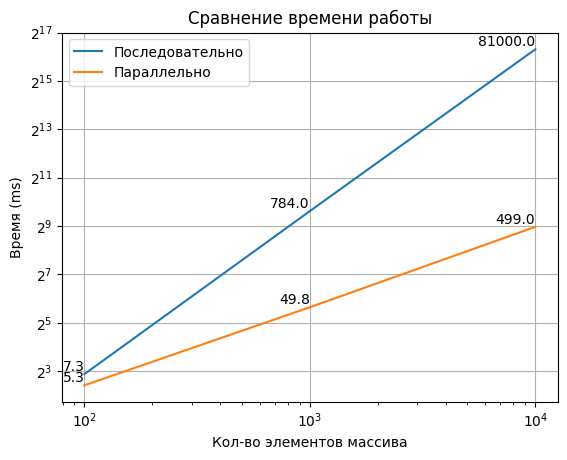

In [37]:
import matplotlib.pyplot as plt

ns = [100, 1000, 10000]
s_times = [7.32, 784., 81000.]
p_times = [5.31, 49.8, 499.]

plt.plot(ns, s_times)
plt.plot(ns, p_times)
for x, y in zip(ns, s_times):
    plt.text(x, y, f'{y:.1f}', ha='right', va='bottom')


plt.title("Сравнение времени работы")
plt.xlabel("Кол-во элементов массива")
plt.ylabel("Время (ms)")
plt.yscale('log', base=2)
plt.xscale('log')
plt.grid(True)
plt.legend(['Последовательно', 'Параллельно'])
plt.xticks(ns)
for x, y in zip(ns, p_times):
    plt.text(x, y, f'{y:.1f}', ha='right', va='bottom')
plt.show()